In [1]:
from sklearn import neighbors, cluster
from sklearn.metrics import pairwise
from sklearn.manifold import SpectralEmbedding

from scipy.spatial.distance import pdist, squareform
import torch
import numpy as np

     |████████████████████████████████| 1.8MB 5.4MB/s 


In [2]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import gc
import collections
from functools import partial

import seaborn as sns

import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%config Completer.use_jedi = False

dev = 'cuda:0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [18]:
class Net(nn.Module):
    def __init__(self, layers, drop_p=0.2):
        super(Net,self).__init__()
        self.hidden = nn.ModuleList()
        for li,lo in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(li, lo))
        self.droput = nn.Dropout(drop_p)
        
    def forward(self,x):
        x = x.view(-1, INPUT_SHAPE)
        for i,l in enumerate(self.hidden):
            x = l(x)
            if i < len(self.hidden) - 1:
                x = F.relu(x)
        return x

def eval_nn(nn, testloader):
    correct = 0
    loss_sublist = []
    for x,y in testloader:
        x,y = x.to(dev), y.to(dev)
        z = nn(x)
        _, yh = torch.max(z.data, 1)
        correct += (yh == y).sum().item()
        loss_sublist.append(crit(z, y).data.item())
    acc = correct / len(testloader.dataset)
    return acc, round(np.mean(loss_sublist), 4)

def run_nn_train(nn, x, y, optimizer, crit):
    x,y = x.to(dev), y.to(dev)
    optimizer.zero_grad()
    z = nn(x)
    return crit(z, y)

def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Simple MLP

In [21]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = Net(layers, drop_p=0.3).to(dev).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [6]:
for epoch in range(20):
    # Train
    for x,y in trainloader:
        loss = run_nn_train(mlp, x, y, optimizer=optimizer, crit=crit)
        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(mlp, testloader)
    del x,y,loss
    clean_mem()

    print(f'{epoch}. Accuracy: {round(acc, 4)}, CE: {test_loss}')

0. Accuracy: 0.7043, CE: 0.8277
1. Accuracy: 0.7802, CE: 0.5952
2. Accuracy: 0.8108, CE: 0.5304


KeyboardInterrupt: ignored

In [ ]:
l1 = dict(mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()

## Graph MLP

In [27]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
n_hidden = len(layers) - 2
ids_per_layer = [sum(layers[1:(i+1)]) + np.arange(layers[i+1], dtype=int) for i in range(n_hidden)]

graph_mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(graph_mlp.parameters(), lr=0.001)
for m in graph_mlp.modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(lambda mod, inp, out: activations.append(out)))

In [28]:
for epoch in range(20):
    # Train
    for x,y in trainloader:
        activations = []
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)

        act = torch.cat(activations, dim=1)
        cov = act.T @ act
        std = cov.diag().pow(1 / 2)
        corr = cov / std / std.unsqueeze(1)
        adj_mat = corr.pow(2)
        degreesqrt = adj_mat.sum(0, keepdims=True).pow(-1. / 2.)
        adjnorm = adj_mat * degreesqrt * degreesqrt.T
        lap = torch.eye(adjnorm.shape[0]).to(dev) - adjnorm.to(dev)
        loss += ((act @ lap) * act).sum() / act.shape[1] * 0.0000001

        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()
    print(f'{epoch}. Accuracy: {round(acc, 4)}, CE: {test_loss}')

0. Accuracy: 0.7682, CE: 0.6701
1. Accuracy: 0.8218, CE: 0.5017
2. Accuracy: 0.8297, CE: 0.4698
3. Accuracy: 0.844, CE: 0.4406
4. Accuracy: 0.849, CE: 0.4208
5. Accuracy: 0.8526, CE: 0.4104
6. Accuracy: 0.8584, CE: 0.3989
7. Accuracy: 0.8573, CE: 0.397
8. Accuracy: 0.8632, CE: 0.3891
9. Accuracy: 0.8617, CE: 0.3832
10. Accuracy: 0.8618, CE: 0.3873
11. Accuracy: 0.8654, CE: 0.3826
12. Accuracy: 0.8604, CE: 0.383
13. Accuracy: 0.865, CE: 0.3736
14. Accuracy: 0.8675, CE: 0.3671
15. Accuracy: 0.8651, CE: 0.3713
16. Accuracy: 0.8684, CE: 0.3643
17. Accuracy: 0.8721, CE: 0.3585
18. Accuracy: 0.8677, CE: 0.3657
19. Accuracy: 0.8709, CE: 0.3584


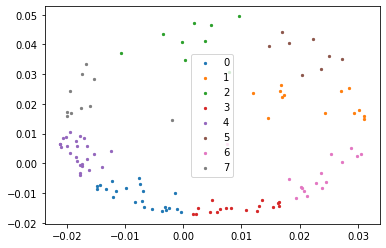

In [29]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat.cpu().detach())
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

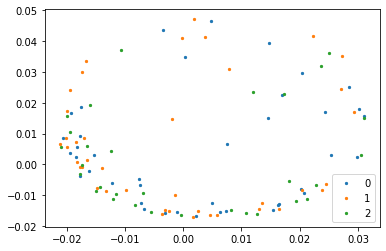

In [30]:
for i,ids in enumerate(ids_per_layer):
    plt.scatter(spec_emb[ids,0], spec_emb[ids,1], s=5, label=i)
plt.legend();

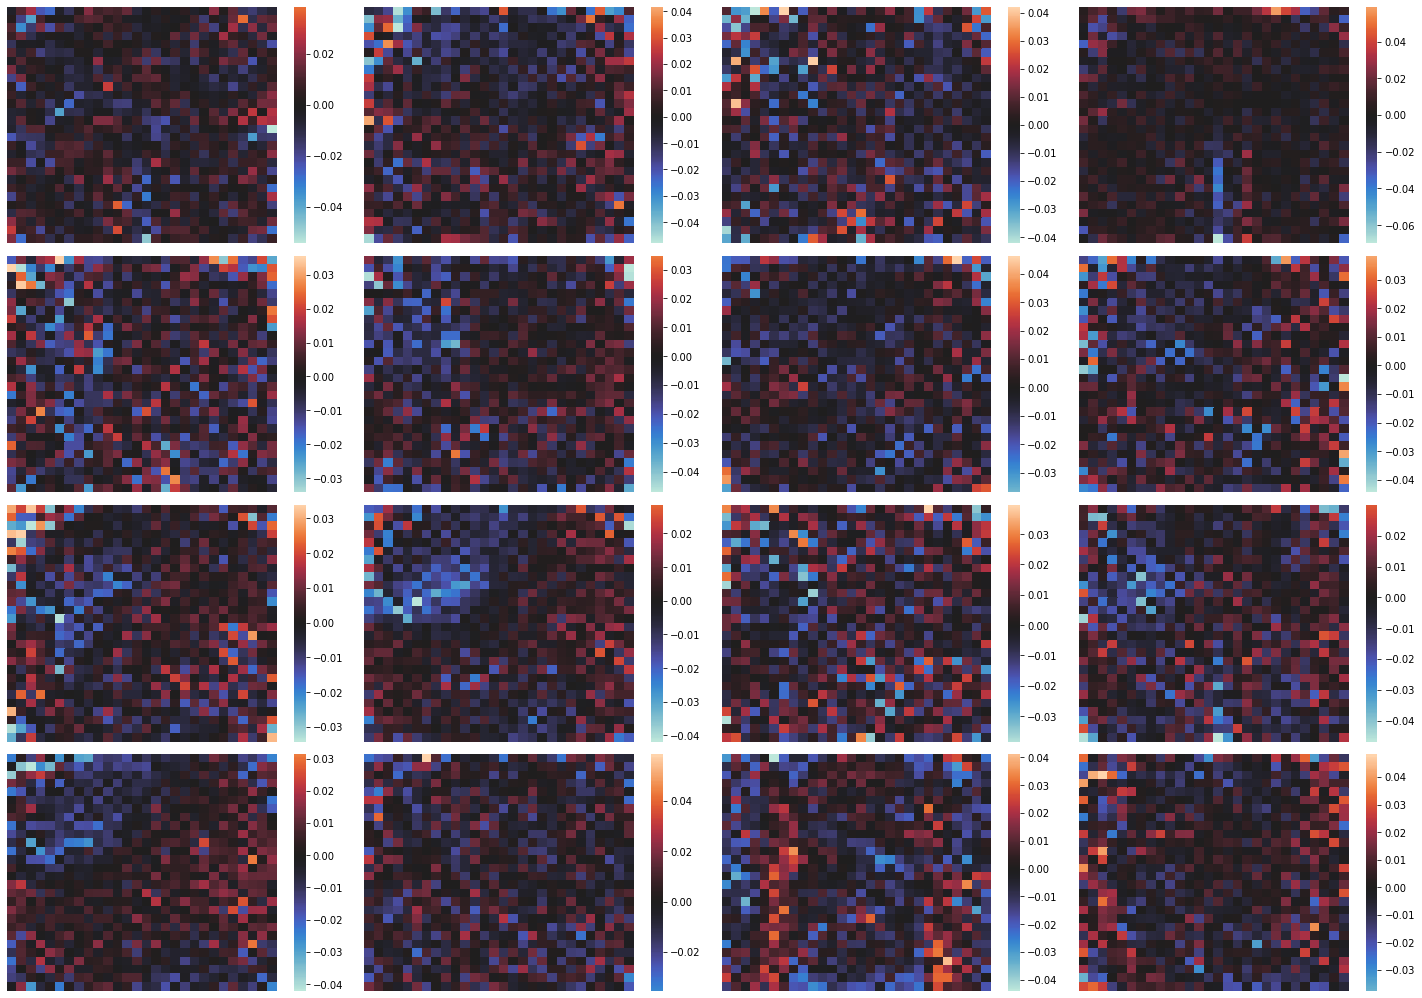

In [25]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()